# Implementing a CGAN for the Titanic data set to generate synthetic data
### Import necessary modules and packages

In [1]:
import os
while os.path.basename(os.getcwd()) != 'CSDGAN':
    os.chdir('..')

import configs.titanic as cfg
from utils.utils import *
from utils.data_loading import load_processed_dataset
import os
from CSDGAN.classes.tabular.TabularCGAN import TabularCGAN
from CSDGAN.classes.tabular.TabularDataset import TabularDataset
from torch.utils import data
import pickle as pkl
import random
%matplotlib inline

/home/aj/miniconda3/lib/python3.7/site-packages/dotenv.py:18: UserWarning: can't read /home/aj/PycharmProjects/CSDGAN/CSDGAN/utils/.env - it doesn't exist.
  warnings.warn("can't read %s - it doesn't exist." % dotenv_path)


### Set random seem for reproducibility

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Inspect config file
I have also implemented a config/titanic.py file for all relevant user inputs for training the model. I recommend checking out this file and playing around with the inputs in order to experiment! I'm curious what results you may find. I will print out the current config setup below so that you have a good idea of the out-of-the-box parameters:

In [3]:
print("Experiment Name:", cfg.EXPERIMENT_NAME)  #  Where output files will be saved
print("Manual Seed:", cfg.MANUAL_SEED)  # This is above

print("\nEvaluation Parameters:")
print("Number of data set pass-throughs per epoch:", cfg.CADENCE)
print("Continuous Features:", cfg.CONT_INPUTS)
print("Integer Features:", cfg.INT_INPUTS)
print("Dependent Variable:", cfg.DEP_VAR)
print("Evaluation Parameter Grid:", cfg.EVAL_PARAM_GRID)
print("Number of cross-validation folds for evaluation:", cfg.EVAL_FOLDS)
print("Generated data set sizes to test for during evaluation:", cfg.TEST_RANGES)

print("\nTraining Parameters:")  # Whether to shuffle the data for training, and number of cpu workers for concurrency
print("Test Set Size:", cfg.TEST_SIZE)  # Number of examples in the test set
print("Total Number of Epochs:", cfg.NUM_EPOCHS)
print("Printing Frequency:", cfg.PRINT_FREQ)  # How often to print results to the console (in epochs)
print("Evaluation Frequency:", cfg.EVAL_FREQ)  # How often to train the evaluator on generated data (in epochs)

for key, value in cfg.TRAINING_PARAMS.items():
    print(key + ": " + str(value))

print("\nCGAN Class Initialization Parameters:")  # See the config file for more detail behind what these choices represent
for key, value in cfg.CGAN_INIT_PARAMS.items():
    print(key + ": " + str(value))

Experiment Name: Titanic_Notebook_Example
Manual Seed: 999

Evaluation Parameters:
Number of data set pass-throughs per epoch: 1
Continuous Features: ['SibSp', 'Parch', 'Fare', 'Age']
Integer Features: ['SibSp', 'Parch']
Dependent Variable: Survived
Evaluation Parameter Grid: {'tol': [1e-05], 'C': [0.5], 'l1_ratio': [0]}
Number of cross-validation folds for evaluation: 5
Generated data set sizes to test for during evaluation: [446, 892, 1784, 3568, 7136]

Training Parameters:
Test Set Size: 445
Total Number of Epochs: 10000
Printing Frequency: 250
Evaluation Frequency: 250
batch_size: 1000
shuffle: False
num_workers: 0

CGAN Class Initialization Parameters:
nc: 2
nz: 64
sched_netG: 1
netG_H: 32
netD_H: 32
netG_lr: 0.0002
netD_lr: 0.0002
netG_beta1: 0.5
netD_beta1: 0.5
netG_beta2: 0.999
netD_beta2: 0.999
netG_wd: 0
netD_wd: 0
label_noise: 0.0
label_noise_linear_anneal: False
discrim_noise: 0.0
discrim_noise_linear_anneal: False


Feel free to play around with some of these!

### Directory for outputs

In [4]:
exp_path = os.path.join("experiments", cfg.EXPERIMENT_NAME)
print("Files for this experiment will end up here:", exp_path)

Files for this experiment will end up here: experiments/Titanic_Notebook_Example


### Import and briefly inspect data

In [5]:
titanic = load_processed_dataset('titanic')
titanic.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,CabinLetter,Title,Age
0,0,3,male,1,0,7.2500,S,NoCabin,Mr.,22.0
1,1,1,female,1,0,71.2833,C,C,Mrs.,38.0
2,1,3,female,0,0,7.9250,S,NoCabin,Miss.,26.0
3,1,1,female,1,0,53.1000,S,C,Mrs.,35.0
4,0,3,male,0,0,8.0500,S,NoCabin,Mr.,35.0


### Automatically determine these parameters and complete preprocessing

In [6]:
device = torch.device('cpu')  # torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")  # could run out of memory
out_dim = titanic.shape[1]
labels_list = list(titanic[cfg.DEP_VAR].unique())

print("Device:", device)
print("Dimensions of a single row:", out_dim)
print("List of labels:", labels_list)

Device: cpu
Dimensions of a single row: 10
List of labels: [0, 1]


### Define and instantiate data set and generator
I'm using Pytorch's built-in datasets and generator classes. The init method of this class takes care of the dirty work of organizing the data set by its continuous and categorical features, through label encoding, one hot encoding, splitting the data into train/test, and transforming the original DataFrame into tensors ready for training. I encourage you to check out the source code (or v1 of the notebook report) to get a better understanding as to what it is doing. 

In [7]:
dataset = TabularDataset(df=titanic,
                         dep_var=cfg.DEP_VAR,
                         cont_inputs=cfg.CONT_INPUTS,
                         int_inputs=cfg.INT_INPUTS,
                         test_size=cfg.TEST_SIZE,
                         seed=cfg.MANUAL_SEED)
dataset.to_dev(device)
data_gen = data.DataLoader(dataset, **cfg.TRAINING_PARAMS)
eval_stratify = list(dataset.y_train.mean(0).detach().cpu().numpy())

print("Size of training data set:", dataset.x_train.shape[0])
print("Size of testing data set:", dataset.x_test.shape[0])
print("Label stratifications applied to evaluator model:", eval_stratify)

Size of training data set: 446
Size of testing data set: 445
Label stratifications applied to evaluator model: [0.61659193, 0.38340807]


/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


### Instantiate the CGAN Class

In [8]:
CGAN = TabularCGAN(data_gen=data_gen,
                   device=device,
                   path=exp_path,
                   seed=cfg.MANUAL_SEED,
                   eval_param_grid=cfg.EVAL_PARAM_GRID,
                   eval_folds=cfg.EVAL_FOLDS,
                   test_ranges=cfg.TEST_RANGES,
                   eval_stratify=eval_stratify,
                   **cfg.CGAN_INIT_PARAMS)

### Visualize Network Architecture
I find it very helpful to draw out the architecture of our networks so I can better understand how I might be able to debug/improve it. Let's take a look!

Generator Architecture


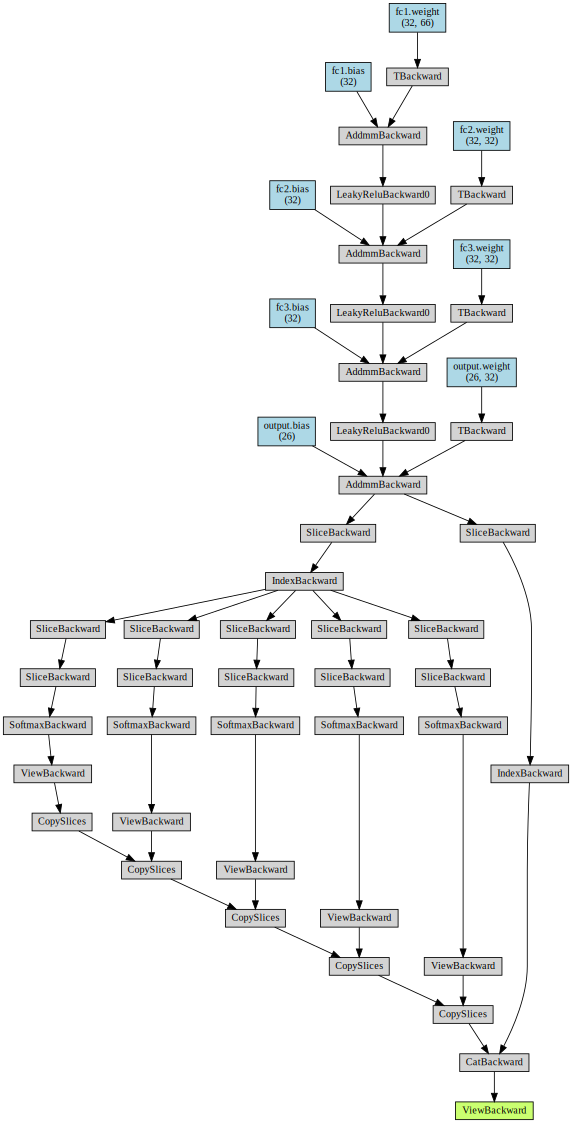

In [9]:
print("Generator Architecture")
viz = CGAN.draw_architecture(net=CGAN.netG, show=False, save=exp_path)
viz

Discriminator Architecture


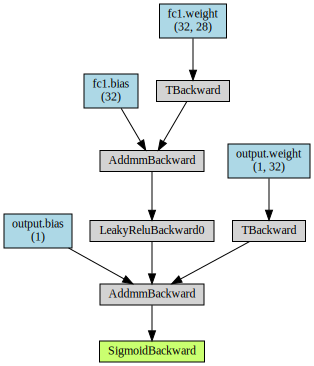

In [10]:
print("Discriminator Architecture")
viz = CGAN.draw_architecture(net=CGAN.netD, show=False, save=exp_path)
viz

### Evaluate performance on real data
Before we train our CGAN, let's train an evaluation model (logistic regression in this case) on the training data in order to come up with a benchmark accuracy that we will try to beat with our generator and evaluator combination.

In [11]:
score_real = train_test_logistic_reg(x_train=CGAN.data_gen.dataset.x_train.cpu().detach().numpy(),
                                     y_train=CGAN.data_gen.dataset.y_train.cpu().detach().numpy(),
                                     x_test=CGAN.data_gen.dataset.x_test.cpu().detach().numpy(),
                                     y_test=CGAN.data_gen.dataset.y_test.cpu().detach().numpy(),
                                     param_grid=cfg.EVAL_PARAM_GRID,
                                     cv=cfg.EVAL_FOLDS,
                                     random_state=cfg.MANUAL_SEED,
                                     labels_list=labels_list,
                                     verbose=True)

Best Accuracy: 81.12%
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-05}
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       274
           1       0.78      0.71      0.74       171

    accuracy                           0.81       445
   macro avg       0.80      0.79      0.80       445
weighted avg       0.81      0.81      0.81       445

[[240  34]
 [ 50 121]]


## Training the GAN
I've condensed the entire training code into a single line. If you are interested, feel free to check out the source code, but the training regimen is extremely similar to the one implemented for the prior data sets. Feel free to grab a coffee (if it doesn't cost more than $5 this doesn't count as science!) while it trains.

In [12]:
CGAN.train_gan(num_epochs=cfg.NUM_EPOCHS, cadence=cfg.CADENCE, print_freq=cfg.PRINT_FREQ, eval_freq=cfg.EVAL_FREQ)

Beginning training
Time: 3s
[250/10000]	Loss_D: 1.3772	Loss_G: 0.7002	D(x): 0.5014	D(G(z)): 0.4968 / 0.4965
Epoch: 250	Evaluator Score: 0.7258
Time: 9s
[500/10000]	Loss_D: 1.3660	Loss_G: 0.7026	D(x): 0.5063	D(G(z)): 0.4958 / 0.4954
Epoch: 500	Evaluator Score: 0.7191
Time: 10s
[750/10000]	Loss_D: 1.3616	Loss_G: 0.7076	D(x): 0.5079	D(G(z)): 0.4949 / 0.4932
Epoch: 750	Evaluator Score: 0.7056
Time: 8s
[1000/10000]	Loss_D: 1.3601	Loss_G: 0.7071	D(x): 0.5078	D(G(z)): 0.4939 / 0.4934
Epoch: 1000	Evaluator Score: 0.6966
Time: 9s
[1250/10000]	Loss_D: 1.3637	Loss_G: 0.6987	D(x): 0.5087	D(G(z)): 0.4965 / 0.4975
Epoch: 1250	Evaluator Score: 0.7483
Time: 9s
[1500/10000]	Loss_D: 1.3599	Loss_G: 0.7050	D(x): 0.5091	D(G(z)): 0.4952 / 0.4943
Epoch: 1500	Evaluator Score: 0.7663
Time: 8s
[1750/10000]	Loss_D: 1.3559	Loss_G: 0.7109	D(x): 0.5097	D(G(z)): 0.4935 / 0.4916
Epoch: 1750	Evaluator Score: 0.7618
Time: 9s
[2000/10000]	Loss_D: 1.3473	Loss_G: 0.7211	D(x): 0.5079	D(G(z)): 0.4873 / 0.4865
Epoch: 2000	Ev

In [13]:
print("Highest score achieved: {0: .2%}".format(np.max(CGAN.stored_acc)))

Highest score achieved:  81.80%


###### Results
Wow! It looks like we succeeded in training a model entirely on fake data that could outperform a model trained on the actual data. This supports the idea that the GAN has achieved a good understanding of the underlying data distributions. We will go into detail and visualize different aspects of the model training in order to get a better understanding of what actually took place.

### Plot evaluation over time
First, let's look at how our estimate of model performance evolved as the model trained 10,000 epochs. Note, the red dashed line on the plot represents the performance of the model trained on real data from earlier. Also, this model may be difficult to see based on the number of tests run, so I encourage you to open up the image saved to your directory to see it better.

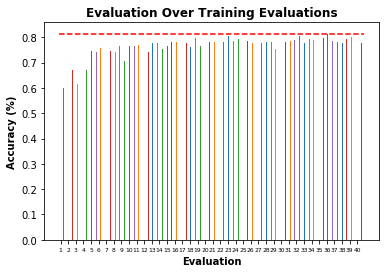

<Figure size 432x288 with 0 Axes>

In [14]:
CGAN.plot_progress(benchmark_acc=score_real, show=True, save=exp_path)

It appears that our model started off in a pretty terrible state (as expected through random initializations of weights), but as training persisted its performance increased to the point where it was semi-consistently beating our benchmark accuracy. Let's load in our best-performing generator, and fit another model to evaluate its performance, mainly as a sanity check that everything is working correctly and to double check that we didn't just get lucky earlier with our high accuracy.

In [15]:
CGAN.load_netG(best=True)
new_acc = CGAN.test_model(stratify=CGAN.eval_stratify)
print("New test accuracy: {0: .2%}".format(np.max(new_acc)))

New test accuracy:  81.80%


### Visualizing model and training diagnostics
Next, let's take a look at some of the training diagnostic plots similar to what we did for the other data sets. I'll leave the interpretation up to you at this point!

/home/aj/PycharmProjects/CSDGAN/CSDGAN/classes/CGANUtils.py:108: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


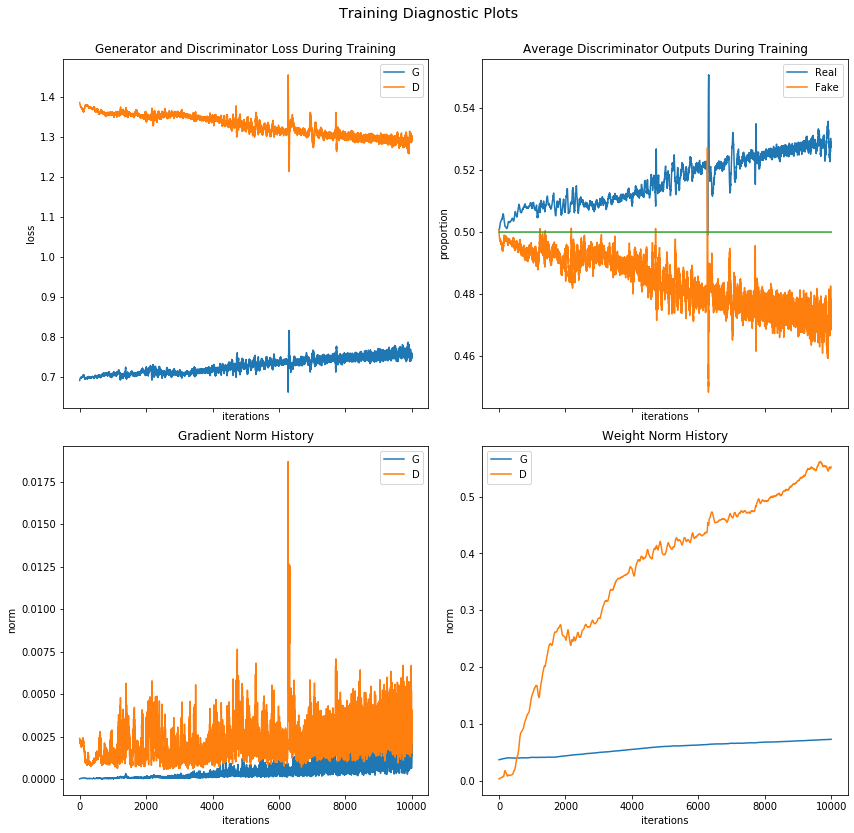

In [16]:
CGAN.plot_training_plots(show=True, save=exp_path)

/home/aj/PycharmProjects/CSDGAN/CSDGAN/classes/NetUtils.py:188: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


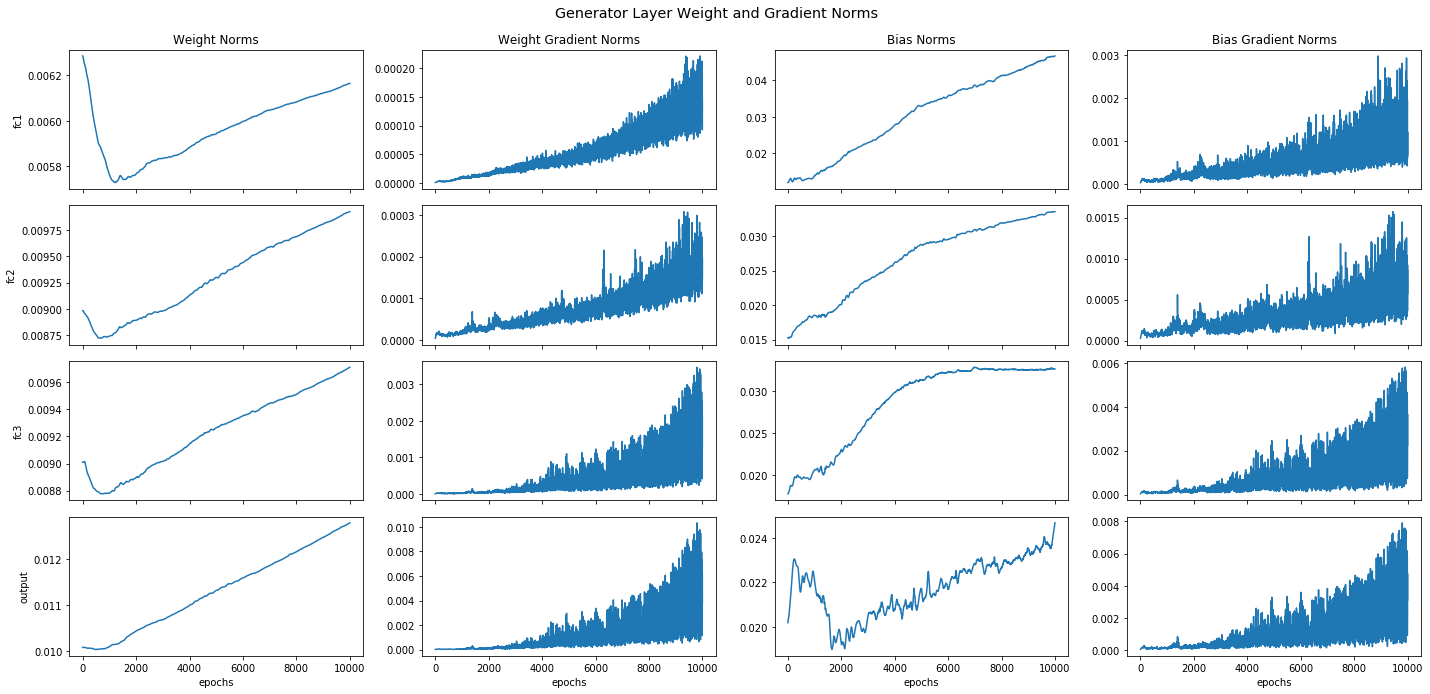

In [17]:
CGAN.netG.plot_layer_scatters(show=True, save=exp_path)

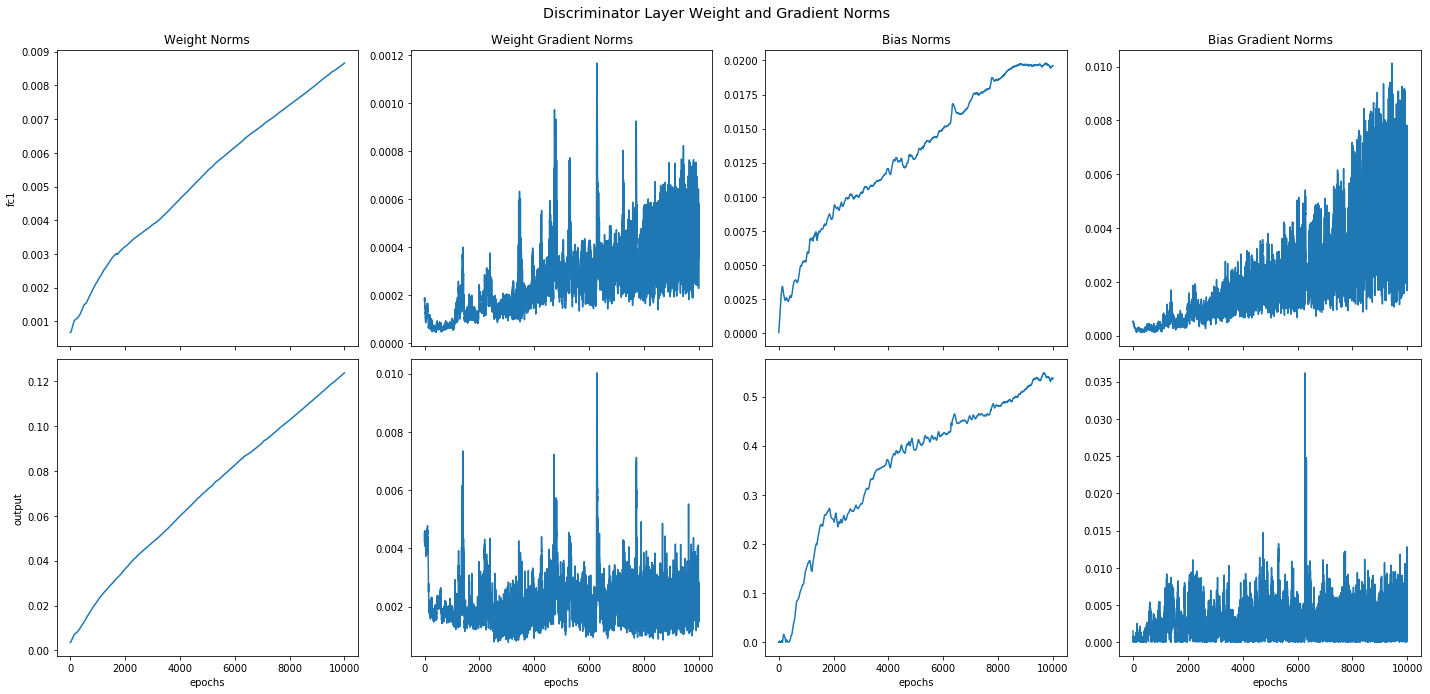

In [18]:
CGAN.netD.plot_layer_scatters(show=True, save=exp_path)

/home/aj/PycharmProjects/CSDGAN/CSDGAN/classes/NetUtils.py:237: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


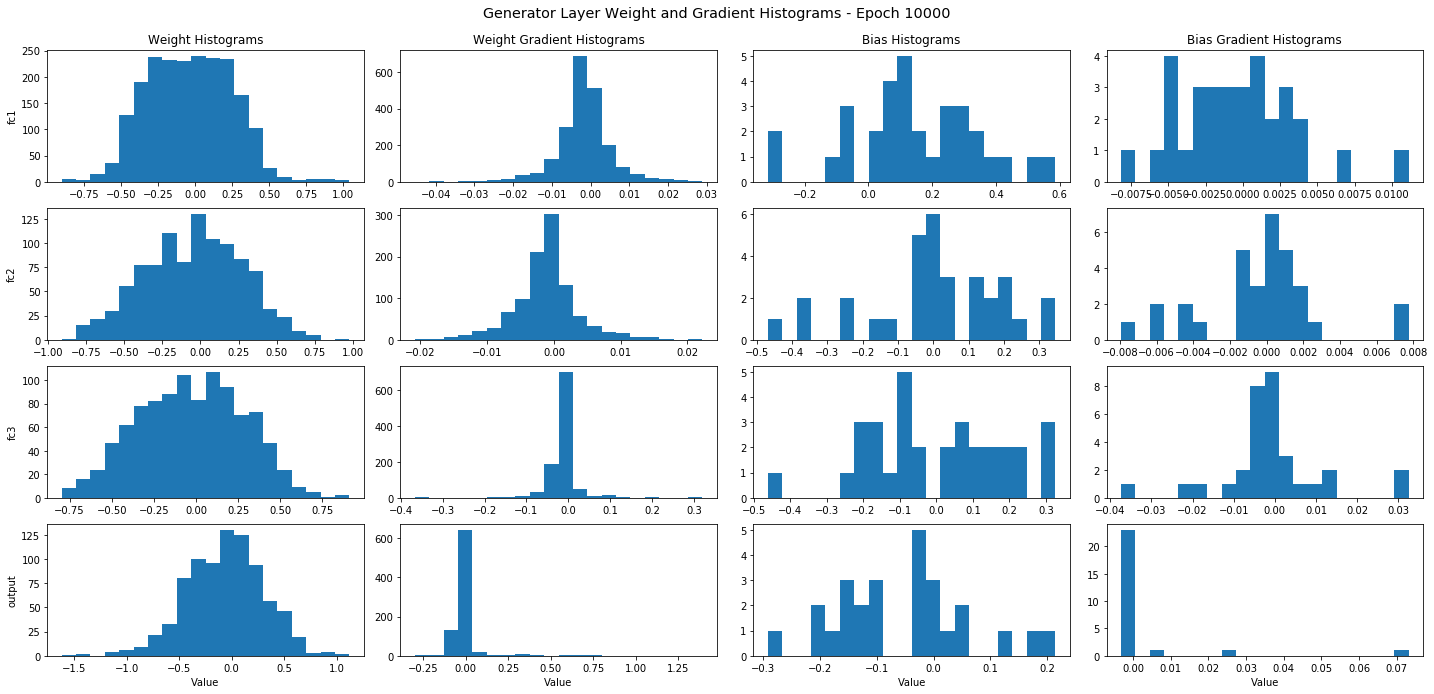

In [19]:
CGAN.netG.plot_layer_hists(show=True, save=exp_path)

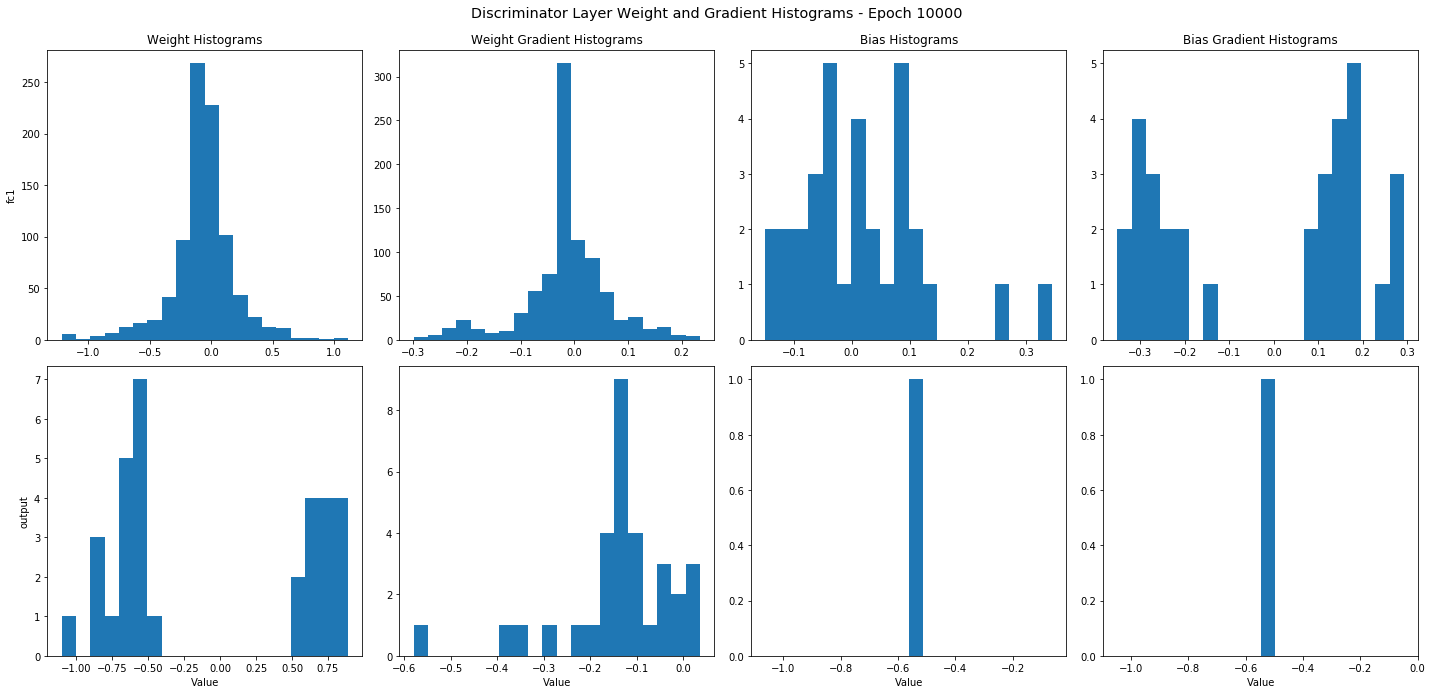

In [20]:
CGAN.netD.plot_layer_hists(show=True, save=exp_path)

### Visualizing data distributions and comparing real vs. fake data
We can also apply various methods to visualize and better understand the results of our newly trained generator. Let's generate a sample DataFrame of data and compare distributions of specific combinations of features.

In [21]:
genned_df = CGAN.gen_data(size=cfg.TEST_RANGES[3], stratify=eval_stratify)
genned_df.sample(5)

,Survived,Pclass,Sex,Embarked,CabinLetter,Title,SibSp,Parch,Fare,Age
544,0,3,male,S,NoCabin,Mr.,0,0,13.524449,36.014030
1958,0,3,male,S,NoCabin,Mr.,0,0,10.449637,40.985565
1314,0,2,female,S,NoCabin,Miss.,0,0,14.778573,44.021763
292,0,3,male,S,NoCabin,Mr.,0,0,9.747294,4.467602
3326,1,1,male,S,C,Mr.,0,0,42.704002,53.041443


In [22]:
titanic.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,CabinLetter,Title,Age
66,0,3,male,1,3,34.3750,S,NoCabin,Mr.,16.000000
879,0,3,male,0,0,56.4958,S,NoCabin,Mr.,29.710003
758,0,3,female,3,1,25.4667,S,NoCabin,Miss.,6.479719
736,0,3,male,0,0,7.8958,S,NoCabin,Mr.,29.450156
326,0,3,female,0,0,8.6625,S,NoCabin,Miss.,20.000000


Looks pretty similar to the original data. Note that I could have rounded the Ages to the nearest whole number, but when we filled in the missing ages with interpolation, more often than not the ages were not integers either. If you hit sample enough times, you may come across odd values, such as SibSp being -1! This could be fixed through additional processing of the generated data, but interestingly enough was ultimately unnecessary to produce a good model.

In [23]:
genned_df.describe()

,Survived,Pclass,SibSp,Parch,Fare,Age
count,3568.000000,3568.000000,3568.000000,3568.000000,3568.000000,3568.000000
mean,0.383408,2.316424,0.419002,0.302971,30.960074,31.272875
std,0.486284,0.831089,0.977830,0.720069,42.615136,12.747583
min,0.000000,1.000000,-1.000000,0.000000,-8.635777,-8.830303
25%,0.000000,2.000000,0.000000,0.000000,10.288372,23.297467
50%,0.000000,3.000000,0.000000,0.000000,16.447227,30.423167
75%,1.000000,3.000000,1.000000,0.000000,31.008013,38.660782
max,1.000000,3.000000,10.000000,6.000000,430.571594,93.839249


In [24]:
titanic.describe()

,Survived,Pclass,SibSp,Parch,Fare,Age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.523008,0.381594,32.204208,29.702509
std,0.486592,0.836071,1.102743,0.806057,49.693429,13.633441
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.420000
25%,0.000000,2.000000,0.000000,0.000000,7.910400,21.155057
50%,0.000000,3.000000,0.000000,0.000000,14.454200,29.450156
75%,1.000000,3.000000,1.000000,0.000000,31.000000,36.250000
max,1.000000,3.000000,8.000000,6.000000,512.329200,80.000000


#### Scatter Matrices

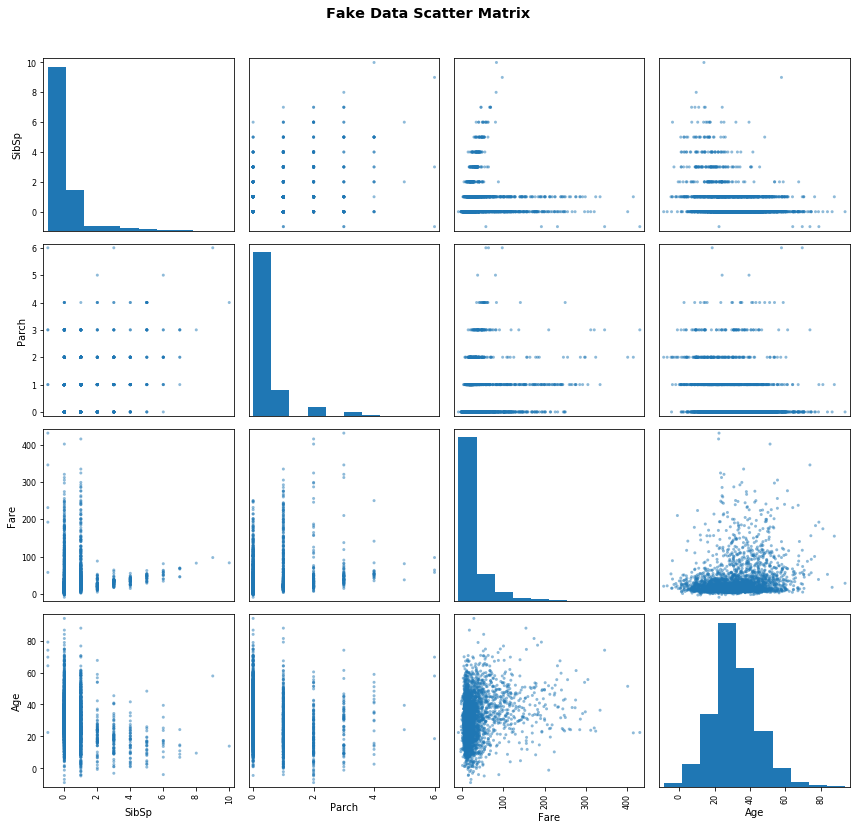

<Figure size 432x288 with 0 Axes>

In [25]:
plot_scatter_matrix(df=genned_df, cont_inputs=cfg.CONT_INPUTS, title="Fake Data", scaler=None, show=True, save=exp_path)

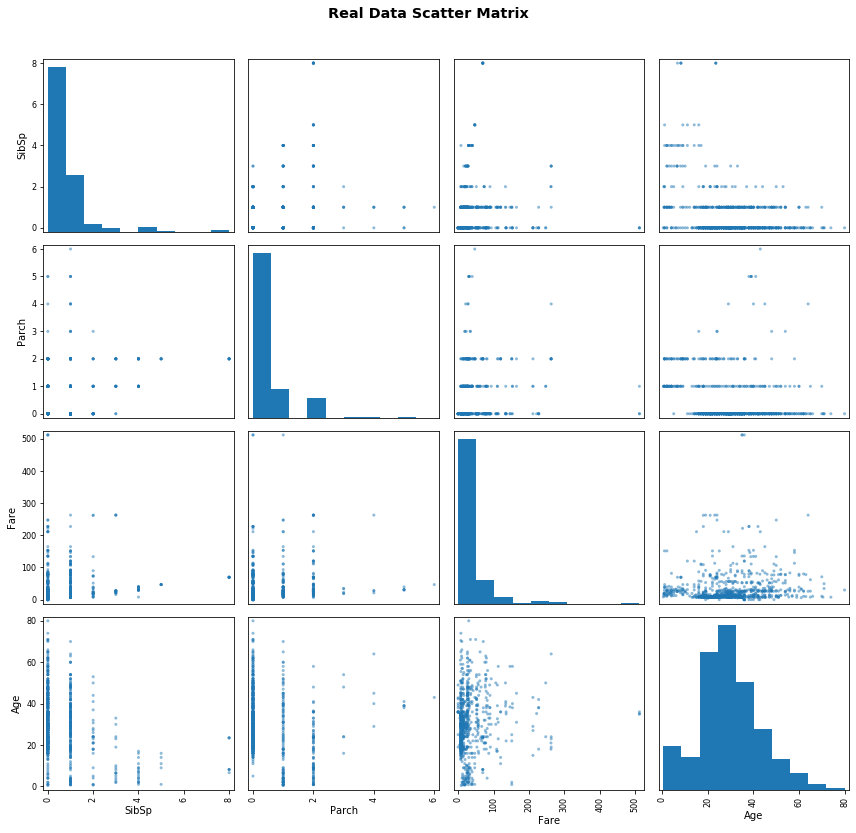

<Figure size 432x288 with 0 Axes>

In [26]:
plot_scatter_matrix(df=titanic, cont_inputs=cfg.CONT_INPUTS, title="Real Data", scaler=None, show=True, save=exp_path)

I think it's really interesting overall how it seems like the GAN tries to push the boundaries and produce values outside of the natural range of values as the number of data points increases. Comparing the two data sets, it almost appears as if the GAN data is just a more intense version of the original data.

#### Categorical Feature Comparisons
I also wrote a helper function to visualize the conditional distribution of 2 categorical variables between the real and fake data. Feel free to play around with the x and hue arguments and set them to whichever categorical variables you prefer!

/home/aj/PycharmProjects/CSDGAN/utils/utils.py:299: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


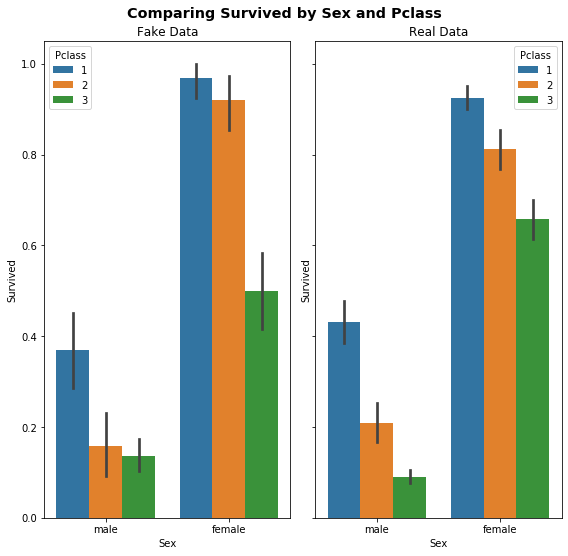

In [27]:
compare_cats(real_df=titanic, fake_df=genned_df, x='Sex', y='Survived', hue='Pclass', show=True, save=exp_path)

#### Conditional Continuous Feature Comparisons
Finally, we can also analyze the conditional scatters and densities of the continuous variables. Feel free to play around with the col arguments of these functions!

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

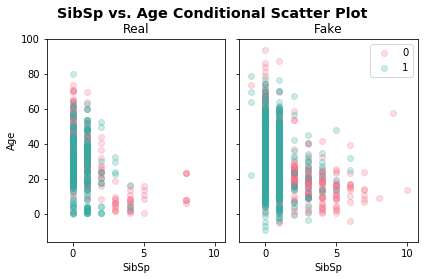

In [28]:
plot_conditional_scatter(col1='SibSp',
                         col2='Age',
                         real_df=titanic,
                         fake_df=genned_df,
                         dep_var=cfg.DEP_VAR,
                         cont_inputs=cfg.CONT_INPUTS,
                         labels_list=labels_list,
                         scaler=None,
                         alpha=0.25,
                         show=True,
                         save=exp_path)

/home/aj/PycharmProjects/CSDGAN/utils/utils.py:208: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


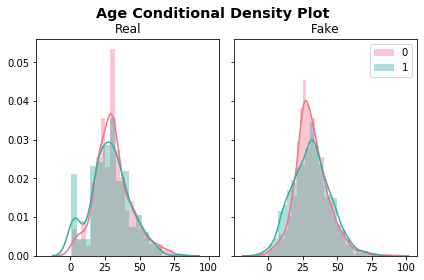

In [29]:
plot_conditional_density(col='Age',
                         real_df=titanic,
                         fake_df=genned_df,
                         dep_var=cfg.DEP_VAR,
                         cont_inputs=cfg.CONT_INPUTS,
                         labels_list=labels_list,
                         scaler=None,
                         show=True,
                         save=exp_path)

I think it's very interesting how it appears the GAN is producing values that are smoother than the real data (resulting from the much larger data set size able to be produced).